#### Libraries

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from IPython.display import Audio, display
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#### Load data

In [5]:
data_path = "data/genres_original"
genres = [g for g in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, g))] # this is to filter out any .DS_Store file

for genre in genres:
    print(f"Genre: {genre}")
    genre_path = os.path.join(data_path, genre)
    files = os.listdir(genre_path)
    print(f"Number of files: {len(files)}")

Genre: pop
Number of files: 100
Genre: metal
Number of files: 100
Genre: disco
Number of files: 100
Genre: blues
Number of files: 100
Genre: reggae
Number of files: 100
Genre: classical
Number of files: 100
Genre: rock
Number of files: 100
Genre: hiphop
Number of files: 100
Genre: country
Number of files: 100
Genre: jazz
Number of files: 100


## Visualising Mel Spectrograms for GTZAN Genres

- This block generates Mel spectrograms for the *first audio file* in each genre folder. 
- It displays them in a 4x4 grid to give a visual comparison of time-frequency characteristics across genres.

Genre: pop
Selected file: pop.00027.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 9.103146112465765e-07 to 1838.7684326171875 dB
--------------------------------------------------
Genre: metal
Selected file: metal.00022.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 3.0769378156492166e-09 to 2060.6181640625 dB
--------------------------------------------------
Genre: disco
Selected file: disco.00052.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 2.9407762891509037e-09 to 504.6983337402344 dB
--------------------------------------------------
Genre: blues
Selected file: blues.00093.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 2.4017798860853645e-09 to 1256.0767822265625 dB
--------------------------------------------------
Genre: reggae
Selected file: reggae.00080.wav
Mel Spectrogram dimensions: (128, 1293)
Mel Spectrogram range: 3.0323866667458788e-05 to 6532.2236328125 dB
-------------------------------

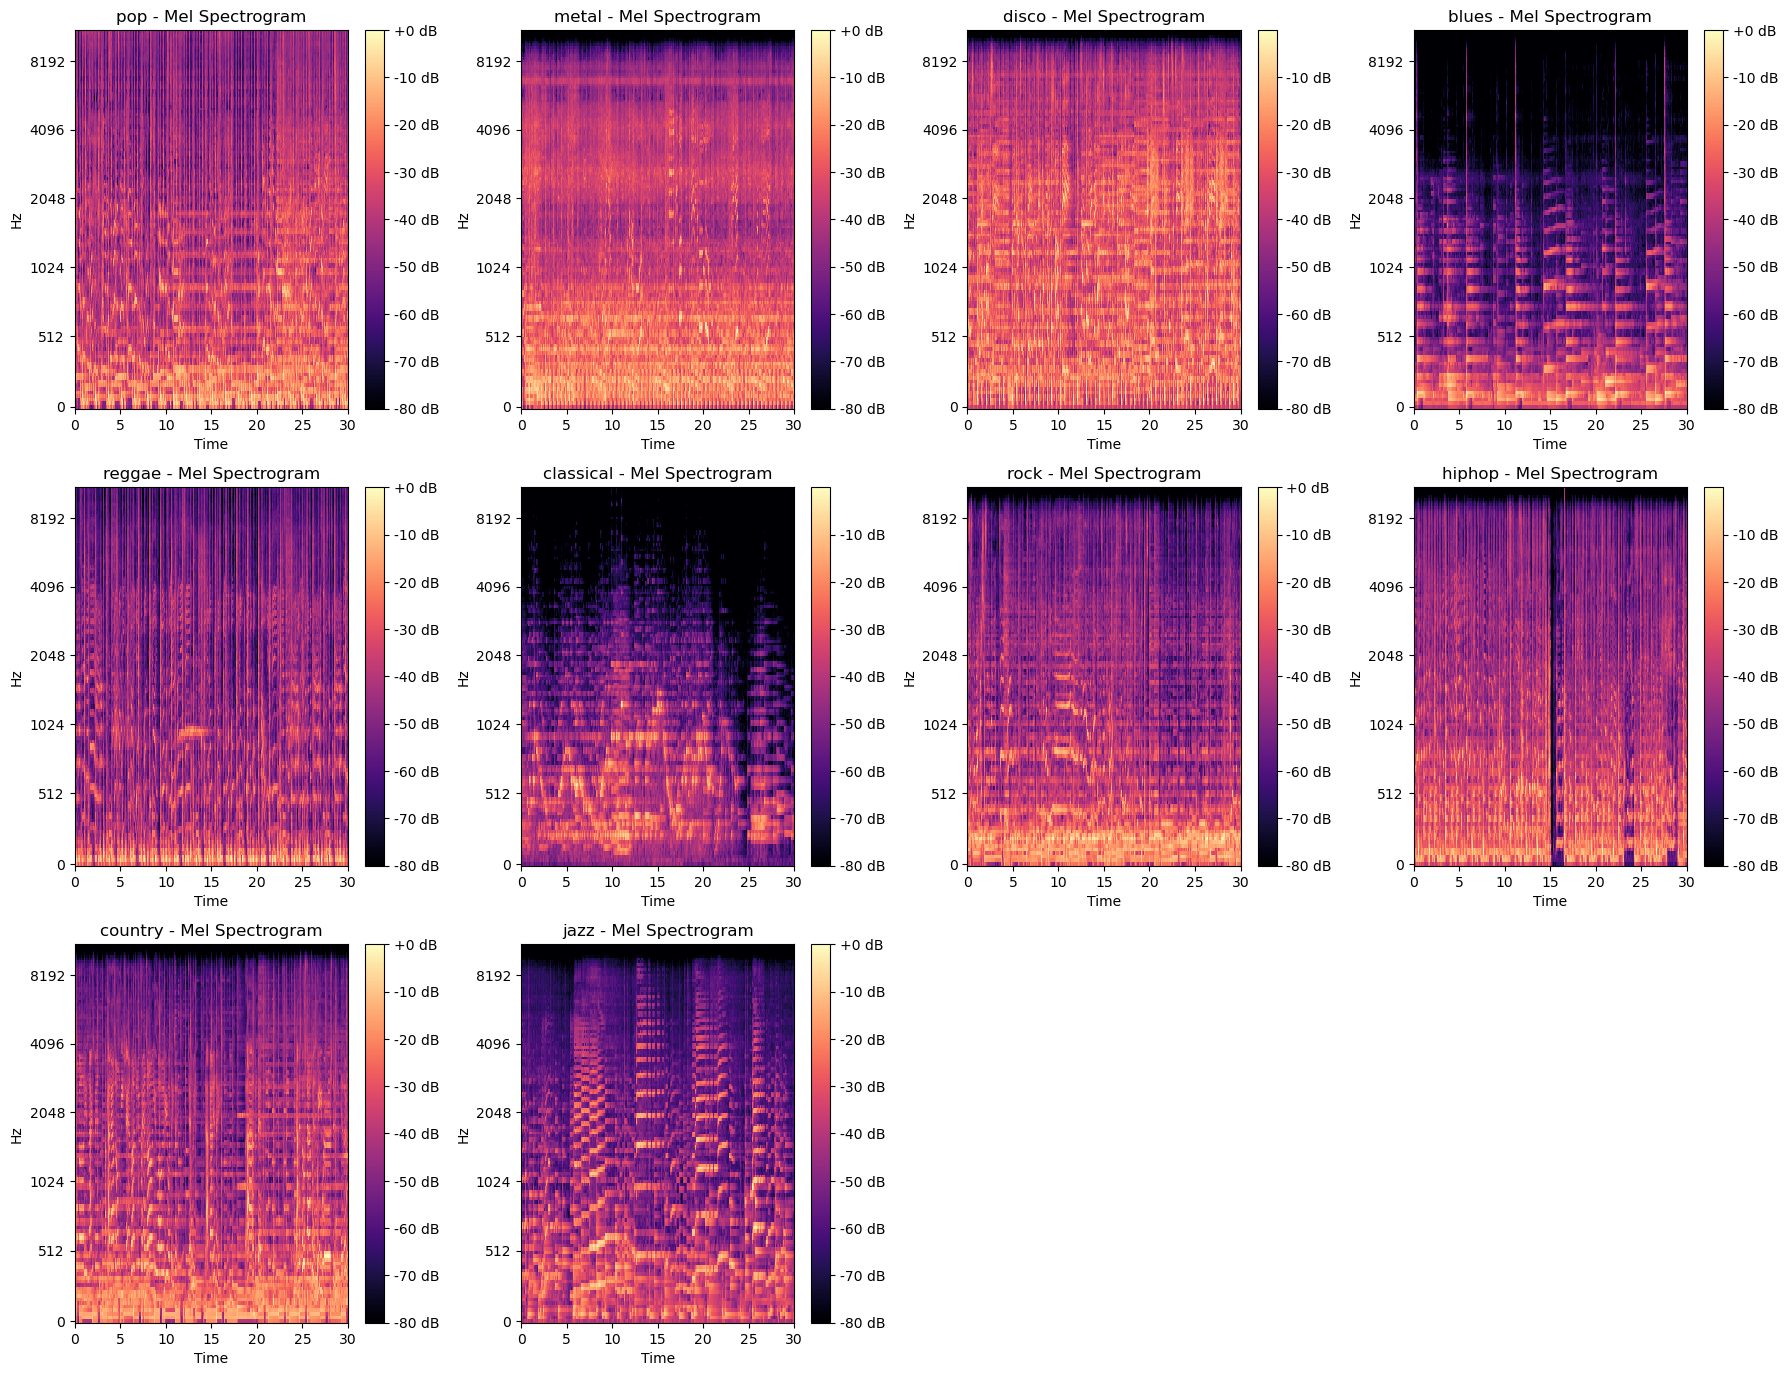

In [6]:
figure, axs = plt.subplots(nrows=4, ncols=4, figsize=(18, 18))
axs = axs.ravel()

for index, genre in enumerate(genres):
    # construct the file paths and load the first audio file for the genre
    path_to_genre = os.path.join(data_path, genre)
    first_file = os.listdir(path_to_genre)[0]
    audio_path = os.path.join(path_to_genre, first_file)
    audio_data, sampling_rate = librosa.load(audio_path)

    # compute the mel spectrogram and convert to decibels
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sampling_rate)
    spectrogram_in_db = librosa.power_to_db(spectrogram, ref=np.max)

    librosa.display.specshow(spectrogram_in_db, ax=axs[index], y_axis='mel', x_axis='time')
    axs[index].set(title=f"{genre} - Mel Spectrogram")
    fig_colorbar = plt.colorbar(axs[index].collections[0], ax=axs[index], format='%+2.0f dB')

    print(f"Genre: {genre}")
    print(f"Selected file: {os.path.basename(audio_path)}")
    print(f"Mel Spectrogram dimensions: {spectrogram.shape}")
    print(f"Mel Spectrogram range: {np.min(spectrogram)} to {np.max(spectrogram)} dB")
    print("-" * 50)

# deactivate unused axs
for j in range(len(genres), 16):
    axs[j].set_visible(False)

figure.tight_layout()
plt.show()

## Breakdown of a Single Audio File

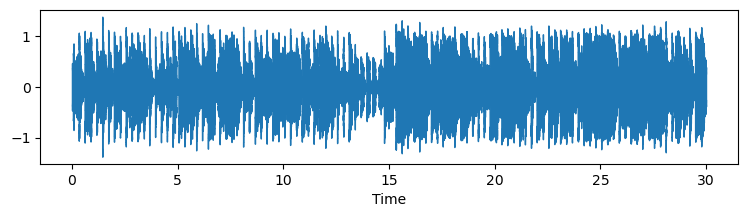

In [10]:
# visualisation of a single file
random_file_path = 'data/genres_original/pop/pop.00020.wav'

x, sr = librosa.load(random_file_path, sr=44100)
display(Audio(data=x, rate=sr))

plt.figure(figsize=(9, 2))
librosa.display.waveshow(x, sr=sr);

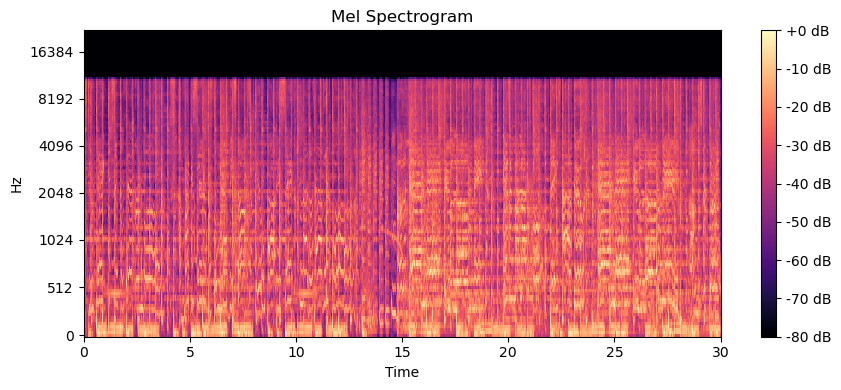

In [11]:
# mel spectogram of the single audio file from above
def create_mel_spectrogram(y, sr):

    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    plt.figure(figsize=(9, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

create_mel_spectrogram(x, sr)

#### Visualising Audio Segmentation
- The following block segments a single audio signal into overlapping 4-second chunks (with 2-second overlap) and visualises each chunk as a waveform. 
- Useful for analysing local temporal patterns within a track.

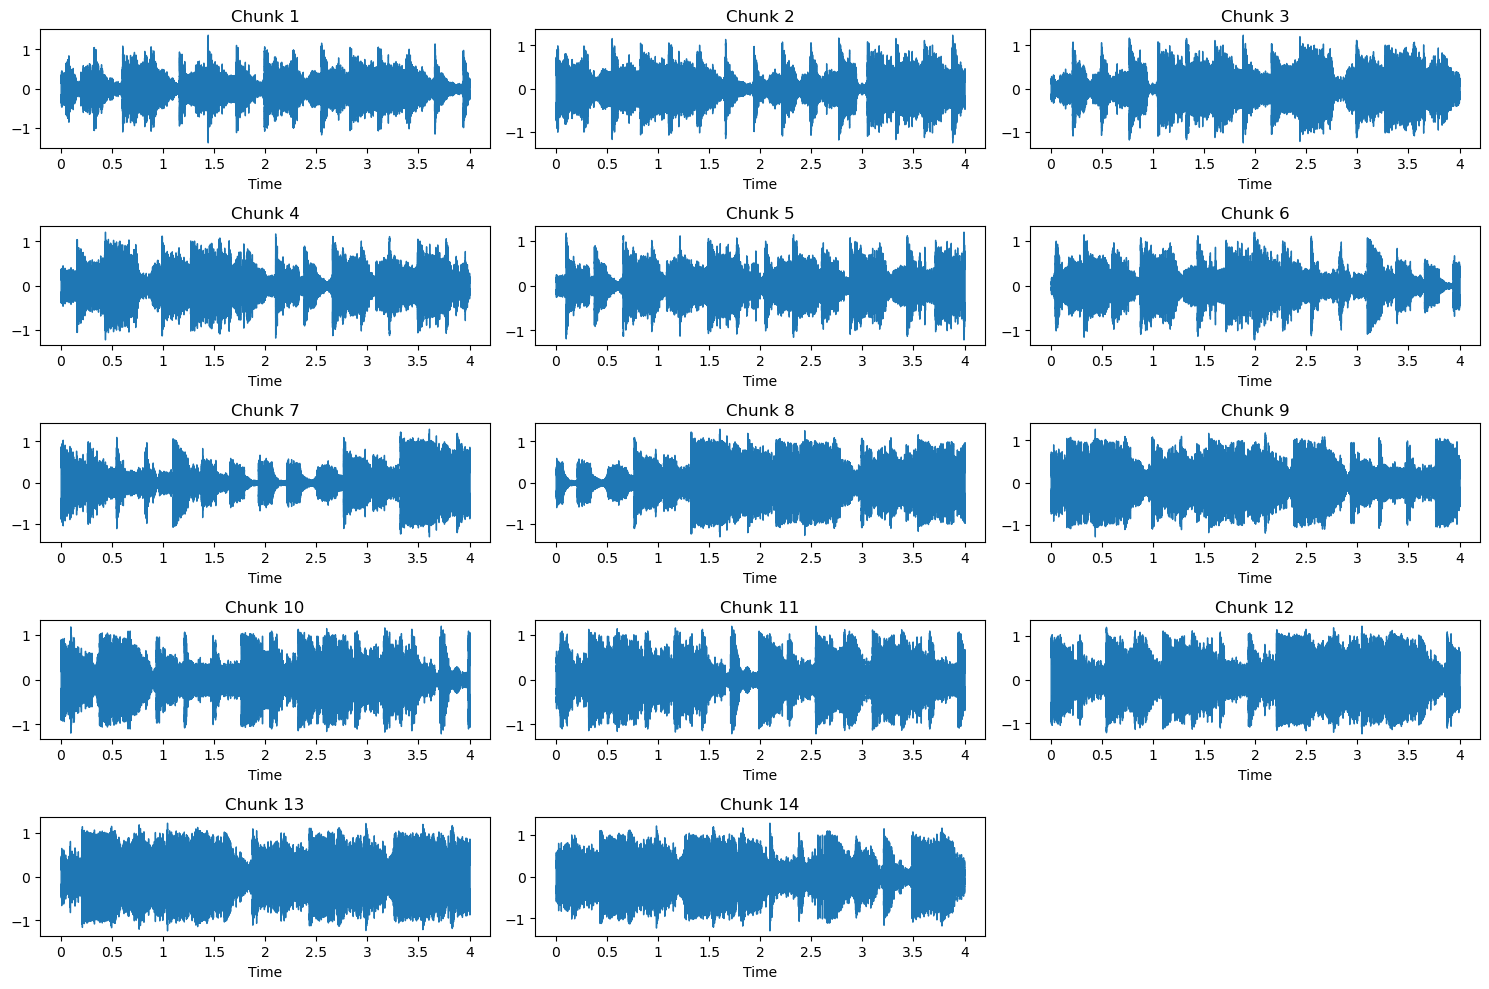

In [12]:
segment_length = 4 * sr  # 4 seconds
overlap = 2 * sr  # 2 seconds
step = segment_length - overlap

# calculate the number of segments
segments = range(0, len(x) - segment_length + 1, step)
num_of_segments = len(segments)

# create subplots
cols = 3  
rows = (num_of_segments + cols - 1) // cols 
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 2 * rows))

for i, start in enumerate(segments):
    end = start + segment_length
    chunk = x[start:end]

    ax = axs.flatten()[i]
    ax.set_title(f'Chunk {i + 1}')
    librosa.display.waveshow(chunk, sr=sr, ax=ax)

# hide any unused subplots
if num_of_segments < rows * cols:
    for idx in range(num_of_segments, rows * cols):
        axs.flatten()[idx].set_visible(False)

plt.tight_layout()
plt.show()

#### Visualising Mel Spectrograms of Overlapping Audio Chunks

- The following block splits an audio signal into overlapping 4-second segments with 2-second overlap (same as above), computes the Mel spectrogram for each chunk, and visualises them. 

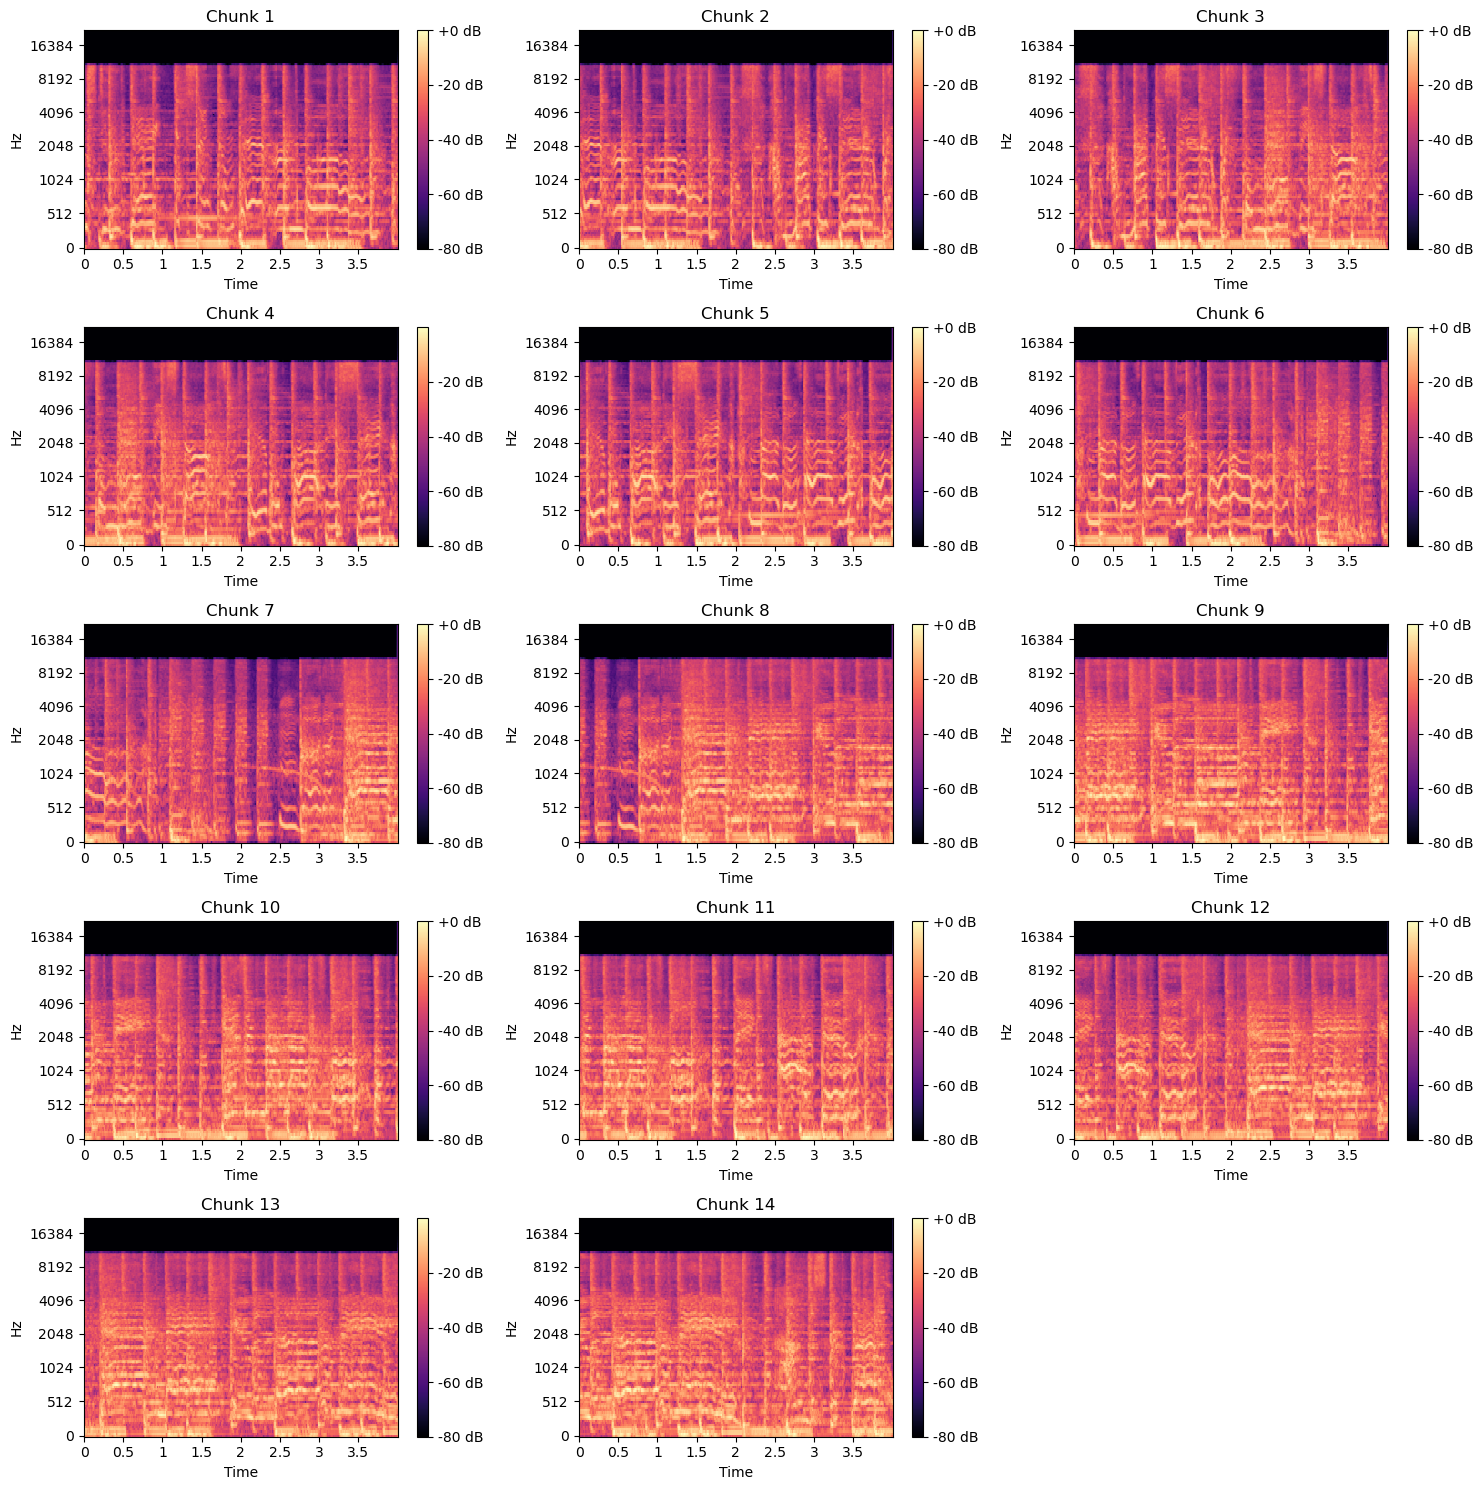

In [13]:
segment_length = 4 * sr 
overlap = 2 * sr  
step = segment_length - overlap

segments = range(0, len(x) - segment_length + 1, step)
num_of_segments = len(segments)

cols = 3  
rows = (num_of_segments + cols - 1) // cols 
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 3 * rows))

for i, start in enumerate(segments):
    end = start + segment_length
    chunk = x[start:end]

    # compute the Mel spectrogram for the chunk
    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # plot the Mel spectrogram
    ax = axs.flatten()[i]
    ax.set_title(f'Chunk {i + 1}')
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
    plt.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')

# hide any unused subplots
if num_of_segments < rows * cols:
    for idx in range(num_of_segments, rows * cols):
        axs.flatten()[idx].set_visible(False)

plt.tight_layout()
plt.show()

## Pre-processing Dataset

In [14]:
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
directory = 'data/genres_original'


def normalize_peak(audio):
    return audio / np.max(np.abs(audio))

def normalize_standard(audio):
    return (audio - np.mean(audio)) / np.std(audio)

def preprocess_audio_files(directory, genres, resized_shape=(150, 150)):
    spectrograms = []
    genre_labels = []
    
    for genre_index, genre in enumerate(genres):        
        genre_directory = os.path.join(directory, genre)
        for file in os.listdir(genre_directory):
            if file.lower().endswith('.wav'):
                audio_path = os.path.join(genre_directory, file)
                audio, rate = librosa.load(audio_path, sr=None)
                audio = normalize_peak(audio)
                
                duration_of_chunk = 4
                overlap = 2
                samples_per_chunk = duration_of_chunk * rate
                samples_overlap = overlap * rate
                total_chunks = int(np.ceil((len(audio) - samples_per_chunk) / (samples_per_chunk - samples_overlap))) + 1
                
                for chunk_number in range(total_chunks):
                    start_sample = chunk_number * (samples_per_chunk - samples_overlap)
                    end_sample = start_sample + samples_per_chunk
                    audio_chunk = audio[start_sample:end_sample]
                    mel_spect = librosa.feature.melspectrogram(y=audio_chunk, sr=rate)
                    resized_mel_spect = resize(np.expand_dims(mel_spect, axis=-1), resized_shape)
                    spectrograms.append(resized_mel_spect)
                    genre_labels.append(genre_index)
    
    return np.array(spectrograms), np.array(genre_labels)

def get_train_test_split(train_size=0.8, test_size=0.2, random_state=42):
    print("Preprocessing audio files...")
    spectrograms, genre_labels = preprocess_audio_files(directory, classes)

    X_train, X_test, y_train, y_test = train_test_split(
        spectrograms,
        genre_labels,
        train_size=train_size,
        test_size=test_size,
        random_state=random_state
    )

    print("Shape of the training set:", X_train.shape)
    print("Shape of the testing set:", X_test.shape)
    print("Shape of the training labels:", y_train.shape)
    print("Shape of the testing labels:", y_test.shape)

    return X_train, X_test, y_train, y_test

def load_dataset(X_train, X_test, y_train, y_test, batch_size=32):
    print("Loading dataset...")

    X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
    X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)
    y_train_tensor = torch.LongTensor(y_train)
    y_test_tensor = torch.LongTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print("Dataset loaded successfully.\n")

    return train_loader, test_loader

In [15]:
# run pre-processing and get splits
X_train, X_test, y_train, y_test = get_train_test_split()

# load into DataLoaders
train_loader, test_loader = load_dataset(X_train, X_test, y_train, y_test)

Preprocessing audio files...
Shape of the training set: (11980, 150, 150, 1)
Shape of the testing set: (2995, 150, 150, 1)
Shape of the training labels: (11980,)
Shape of the testing labels: (2995,)
Loading dataset...
Dataset loaded successfully.



#### Dataset Overview and Class Distribution

In [16]:
print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip([classes[i] for i in unique], counts))
print("Training class distribution:", class_distribution)

Number of training samples: 11980
Number of test samples: 2995
Training class distribution: {'blues': 1198, 'classical': 1200, 'country': 1180, 'disco': 1187, 'hiphop': 1221, 'jazz': 1174, 'metal': 1198, 'pop': 1211, 'reggae': 1204, 'rock': 1207}


#### Spectrogram Shape and Structure

In [17]:
print("Spectrogram shape (single sample):", X_train[0].shape)

Spectrogram shape (single sample): (150, 150, 1)


#### Visualise Sample Mel Spectrograms

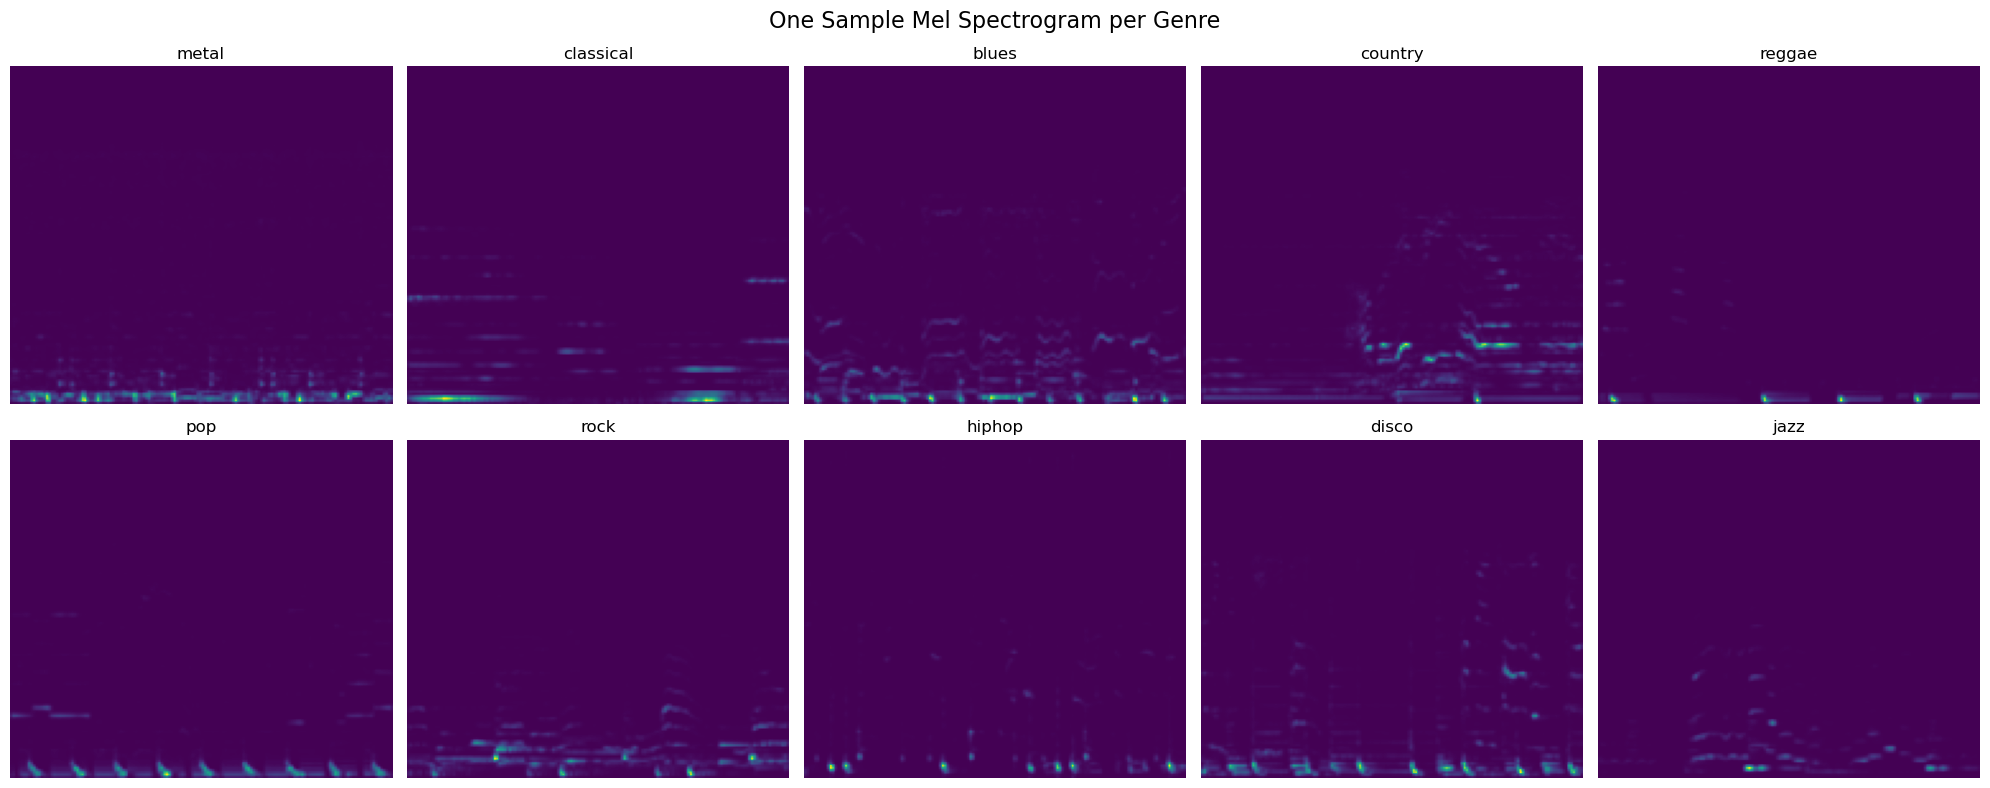

In [27]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

plotted_classes = set()

# loop through training data and pick one example per genre
plotted = 0
for i in range(len(X_train)):
    label = y_train[i]
    if label not in plotted_classes:
        row = plotted // 5
        col = plotted % 5
        axs[row, col].imshow(X_train[i].squeeze(), aspect='auto', origin='lower')
        axs[row, col].set_title(f"{classes[label]}")
        axs[row, col].axis('off')
        plotted_classes.add(label)
        plotted += 1
    if plotted == 10:
        break

plt.suptitle("One Sample Mel Spectrogram per Genre", fontsize=16)
plt.tight_layout()
plt.show()

#### Inspecting a Sample Batch from DataLoader

In [28]:
sample_batch = next(iter(train_loader))

X_batch, y_batch = sample_batch

print("Sample batch - X shape:", X_batch.shape)  
print("Sample batch - y shape:", y_batch.shape)  

Sample batch - X shape: torch.Size([32, 1, 150, 150])
Sample batch - y shape: torch.Size([32])
